# IIT 4316 Deep Learning<br>Homework #2-1: CNN

# 1. Define.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm as tq


DIGITS     = ['0','1','2','3','4','5','6','7','8','9']
VOCAB_SIZE = len(DIGITS)
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Fixed hyperparameters
INPUT_LEN     = 4
OUTPUT_LEN    = 3
LEARNING_RATE = 7e-3
NUM_EPOCH     = 5000
BATCH_SIZE    = 128

# Changable hyperparameters
EMBED_DIM      = 2
CONV_LAYER_NUM = 2
NUM_CHANNELS   = 16

char_to_idx = {c: i for i, c in enumerate(DIGITS)}
idx_to_char = {i: c for i, c in enumerate(DIGITS)}

# batch data generation
def generate_batch(batch_size=100):
    inputs, targets = [], []
    for _ in range(batch_size):
        tens1, ones1 = random.randint(0, 9), random.randint(0, 9)
        tens2, ones2 = random.randint(0, 9), random.randint(0, 9)
        num1, num2 = tens1 * 10 + ones1, tens2 * 10 + ones2
        s = num1 + num2
        inputs.append([tens1, ones1, tens2, ones2])
        sum_str = f"{s:03d}"
        targets.append([char_to_idx[c] for c in sum_str])
    return (torch.tensor(inputs, dtype=torch.long).to(DEVICE),
            torch.tensor(targets, dtype=torch.long).to(DEVICE))

# ReLU
def my_relu(x):
    return torch.clamp(x, min=0.0)

#------------------------------------
# 4 digits to one-hot vectors
#------------------------------------
def MyOneHot(x, vocab_size):    
    B, L = x.size()     # batch size x INPUT_LEN

    ############################################################################
    # TODO: Convert x to one-hot
    ############################################################################

    # Create zero tensor of shape (B, L, vocab_size)
    out = torch.zeros(B, L, vocab_size, device=x.device)
    # Use scatter to fill in the one-hot encoding
    out.scatter_(2, x.unsqueeze(2), 1.0)

    ############################################################################
    # END TODO
    ############################################################################

    return out   # B x L x vocab_size

#------------------------------------
# Embedding layer
#------------------------------------
class MyEmbedding(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(vocab_size, dim) * 0.1)

    def forward(self, x):
        B, L = x.size()

        ############################################################################
        # TODO: Convert x to one-hot and then embedding
        #    Use MyOneHot() function above
        ############################################################################

        # Convert to one-hot: (B, L, vocab_size)
        one_hot = MyOneHot(x, self.weight.size(0))
        # Matrix multiply with embedding weight: (B, L, vocab_size) @ (vocab_size, dim) = (B, L, dim)
        out = torch.matmul(one_hot, self.weight)
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x L x dim

#------------------------------------
# Linear layer
#------------------------------------
class MyLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) * 0.1)
        self.bias   = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):

        ############################################################################
        # TODO: Compute linear layer output
        #   You should implement your own linear layer operation.
        ############################################################################
            
        # x: (..., in_dim), weight: (out_dim, in_dim), bias: (out_dim)
        # out = x @ W^T + bias
        out = torch.matmul(x, self.weight.t()) + self.bias
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  

#------------------------------------
# Conv layer (im2col based - no explicit for loops over spatial dimensions)
#------------------------------------
class MyConv2D(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1):
        super().__init__()

        self.in_channel  = in_channel
        self.out_channel = out_channel
        self.kernel      = kernel_size
        self.pad         = padding
        
        self.weight = nn.Parameter(torch.randn(out_channel, in_channel, kernel_size, kernel_size) * 0.1)
        self.bias   = nn.Parameter(torch.zeros(out_channel))

    def forward(self, x):
        B, C, H, W = x.shape

        ############################################################################
        # TODO: 2D convolution operation
        #   You should implement your own convolution operation.
        #   Using im2col technique for vectorized computation (no for loops)
        ############################################################################

        # Pad the input
        if self.pad > 0:
            x_padded = torch.zeros(B, C, H + 2 * self.pad, W + 2 * self.pad, device=x.device)
            x_padded[:, :, self.pad:self.pad + H, self.pad:self.pad + W] = x
        else:
            x_padded = x
        
        H_pad, W_pad = x_padded.shape[2], x_padded.shape[3]
        
        # Output dimensions (stride=1)
        H_out = H_pad - self.kernel + 1
        W_out = W_pad - self.kernel + 1
        
        # ============================================================
        # im2col: Extract all patches and reshape for matrix multiplication
        # ============================================================
        
        # Create indices for extracting patches using advanced indexing
        # This avoids explicit for loops over spatial dimensions
        
        # Row and column base indices for kernel
        i0 = torch.arange(self.kernel, device=x.device)  # (kernel,)
        j0 = torch.arange(self.kernel, device=x.device)  # (kernel,)
        
        # Offset indices for output positions
        i_offset = torch.arange(H_out, device=x.device)  # (H_out,)
        j_offset = torch.arange(W_out, device=x.device)  # (W_out,)
        
        # Create 2D index grids using outer addition
        # i_idx[a, b] = i0[a] + i_offset[b] for all patches
        # Shape: (kernel, H_out)
        i_idx = i0.view(-1, 1) + i_offset.view(1, -1)  # (kernel, H_out)
        # Shape: (kernel, W_out)  
        j_idx = j0.view(-1, 1) + j_offset.view(1, -1)  # (kernel, W_out)
        
        # Extract all patches using advanced indexing
        # x_padded[:, :, i_idx, :] gives (B, C, kernel, H_out, W_pad)
        # then indexing with j_idx on last dim
        # x_padded: (B, C, H_pad, W_pad)
        
        # Use meshgrid-like indexing to get all patch positions
        # i_idx: (kernel, H_out) -> need (kernel, 1, H_out, 1) for broadcasting
        # j_idx: (kernel, W_out) -> need (1, kernel, 1, W_out) for broadcasting
        
        # Reshape for 4D patch extraction
        i_idx_4d = i_idx.view(self.kernel, 1, H_out, 1).expand(self.kernel, self.kernel, H_out, W_out)
        j_idx_4d = j_idx.view(1, self.kernel, 1, W_out).expand(self.kernel, self.kernel, H_out, W_out)
        
        # Extract patches: (B, C, kernel, kernel, H_out, W_out)
        patches = x_padded[:, :, i_idx_4d, j_idx_4d]
        
        # Reshape for matrix multiplication
        # patches: (B, C, kernel, kernel, H_out, W_out) -> (B, C*kernel*kernel, H_out*W_out)
        patches = patches.permute(0, 1, 2, 3, 4, 5).reshape(B, C * self.kernel * self.kernel, H_out * W_out)
        
        # Reshape weight: (out_channel, in_channel, kernel, kernel) -> (out_channel, C*kernel*kernel)
        weight_reshaped = self.weight.view(self.out_channel, -1)
        
        # Matrix multiplication using bmm (batch matrix multiplication)
        # weight_reshaped: (out_channel, C*k*k)
        # patches: (B, C*k*k, H_out*W_out)
        # Result: (B, out_channel, H_out*W_out)
        weight_expanded = weight_reshaped.unsqueeze(0).expand(B, -1, -1)  # (B, out_channel, C*k*k)
        out = torch.bmm(weight_expanded, patches)  # (B, out_channel, H_out*W_out)
        
        # Add bias and reshape to output dimensions
        out = out + self.bias.view(1, -1, 1)
        out = out.view(B, self.out_channel, H_out, W_out)

        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x out_ch x H x W

#------------------------------------
# CNN model
#------------------------------------
class MyCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_channels, num_conv_layers):
        super().__init__()

        ############################################################################
        # TODO: Define each layer (embedding, conv1, conv2, ..., fc)
        #     Use MyEmbedding, MyConv2D, MyLinear classes defined above.
        ############################################################################
        
        self.embed_dim       = embed_dim
        self.num_channels    = num_channels
        self.num_conv_layers = num_conv_layers
        
        # Embedding layer
        self.embedding = MyEmbedding(vocab_size, embed_dim)
        
        # Conv layers using nn.ModuleList for dynamic number of layers
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            if i == 0:
                # First conv: in_channel = embed_dim, out_channel = num_channels
                self.conv_layers.append(MyConv2D(embed_dim, num_channels, kernel_size=3, padding=1))
            else:
                # Subsequent convs: in_channel = num_channels, out_channel = num_channels
                self.conv_layers.append(MyConv2D(num_channels, num_channels, kernel_size=3, padding=1))
        
        # FC layer: input is flattened conv output (2 * 2 * num_channels), output is 3 * VOCAB_SIZE
        self.fc = MyLinear(2 * 2 * num_channels, OUTPUT_LEN * vocab_size)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):
        B = x.size(0)

        ############################################################################
        # TODO: Define forward path: 
        #    embedding -> reshape -> conv1 -> ReLU -> conv2 -> ReLU -> ... -> flatten -> fc
        ############################################################################

        # Embedding: (B, 4) -> (B, 4, embed_dim)
        out = self.embedding(x)

        # Reshape to image-like: (B, 4, embed_dim) -> (B, embed_dim, 2, 2)
        out = out.permute(0, 2, 1)  # (B, embed_dim, 4)
        out = out.view(B, self.embed_dim, 2, 2)  # (B, embed_dim, 2, 2)
        
        # Apply conv layers with ReLU
        for conv in self.conv_layers:
            out = conv(out)  # (B, num_channels, 2, 2)
            out = my_relu(out)
        
        # Flatten
        out = out.view(B, -1)  # (B, 2*2*num_channels)
        
        # FC layer
        out = self.fc(out)  # (B, 3*VOCAB_SIZE)
        
        # Reshape to (B, 3, VOCAB_SIZE)
        out = out.view(B, OUTPUT_LEN, VOCAB_SIZE)

        ############################################################################
        # END TODO
        ############################################################################

        return out    # B x 3 x VOCAB_SIZE


# 2. Run.

In [25]:
# -----------------------------------------------------------
# Training & test
# -----------------------------------------------------------
torch.manual_seed(42)
random.seed(42)

model     = MyCNN(VOCAB_SIZE, EMBED_DIM, NUM_CHANNELS, CONV_LAYER_NUM).to(DEVICE)
optim     = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in tq(range(1, NUM_EPOCH+1)):   
    model.train()
    src, tgt = generate_batch(BATCH_SIZE)
    logits   = model(src)
    loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))

    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}")

# Evaluation
model.eval()
correct = 0
total   = 0
with torch.no_grad():
    src, tgt = generate_batch(100)
    logits   = model(src)
    preds    = logits.argmax(-1)
    for s, t, p in zip(src.cpu().tolist(), tgt.cpu().tolist(), preds.cpu().tolist()):
        s_str = f"{s[0]}{s[1]} + {s[2]}{s[3]}"
        t_str = ''.join(idx_to_char[x] for x in t)
        p_str = ''.join(idx_to_char[x] for x in p)
        print(f"src: {s_str} = {t_str} | pred: {p_str}")
        if t_str == p_str:
            correct += 1
        total += 1
print(f"Correct: {correct}/{total}")


  1%|          | 32/5000 [00:00<00:36, 135.82it/s]

Epoch 001  Loss: 2.3011
Epoch 050  Loss: 1.6250


  2%|▏         | 124/5000 [00:00<00:20, 234.97it/s]

Epoch 100  Loss: 1.4541
Epoch 150  Loss: 1.2622


  5%|▌         | 250/5000 [00:01<00:16, 292.04it/s]

Epoch 200  Loss: 0.9371
Epoch 250  Loss: 0.6010


  7%|▋         | 344/5000 [00:01<00:15, 299.47it/s]

Epoch 300  Loss: 0.5541
Epoch 350  Loss: 0.3673


  9%|▉         | 444/5000 [00:01<00:14, 319.04it/s]

Epoch 400  Loss: 0.3371
Epoch 450  Loss: 0.2326


 11%|█         | 543/5000 [00:01<00:13, 321.86it/s]

Epoch 500  Loss: 0.1599
Epoch 550  Loss: 0.1564


 13%|█▎        | 642/5000 [00:02<00:13, 324.83it/s]

Epoch 600  Loss: 0.1862
Epoch 650  Loss: 0.1034


 15%|█▍        | 742/5000 [00:02<00:13, 324.65it/s]

Epoch 700  Loss: 0.0899
Epoch 750  Loss: 0.0911


 17%|█▋        | 842/5000 [00:02<00:12, 324.87it/s]

Epoch 800  Loss: 0.0550
Epoch 850  Loss: 0.0612


 19%|█▉        | 941/5000 [00:03<00:12, 324.60it/s]

Epoch 900  Loss: 0.0559
Epoch 950  Loss: 0.0701


 21%|██        | 1040/5000 [00:03<00:12, 325.49it/s]

Epoch 1000  Loss: 0.0449
Epoch 1050  Loss: 0.0636


 23%|██▎       | 1140/5000 [00:03<00:12, 313.37it/s]

Epoch 1100  Loss: 0.0384
Epoch 1150  Loss: 0.0367


 25%|██▍       | 1241/5000 [00:04<00:11, 322.47it/s]

Epoch 1200  Loss: 0.0267
Epoch 1250  Loss: 0.0273


 27%|██▋       | 1340/5000 [00:04<00:11, 321.12it/s]

Epoch 1300  Loss: 0.0156
Epoch 1350  Loss: 0.0146


 29%|██▉       | 1440/5000 [00:04<00:10, 328.14it/s]

Epoch 1400  Loss: 0.0105
Epoch 1450  Loss: 0.0205


 31%|███       | 1542/5000 [00:05<00:10, 330.10it/s]

Epoch 1500  Loss: 0.0822
Epoch 1550  Loss: 0.0267


 33%|███▎      | 1642/5000 [00:05<00:10, 323.60it/s]

Epoch 1600  Loss: 0.0231
Epoch 1650  Loss: 0.0221


 35%|███▍      | 1742/5000 [00:05<00:09, 327.88it/s]

Epoch 1700  Loss: 0.0041
Epoch 1750  Loss: 0.0048


 37%|███▋      | 1844/5000 [00:05<00:09, 321.77it/s]

Epoch 1800  Loss: 0.0423
Epoch 1850  Loss: 0.0049


 39%|███▉      | 1943/5000 [00:06<00:09, 320.95it/s]

Epoch 1900  Loss: 0.0117
Epoch 1950  Loss: 0.0518


 41%|████      | 2042/5000 [00:06<00:09, 324.49it/s]

Epoch 2000  Loss: 0.0102
Epoch 2050  Loss: 0.0049


 43%|████▎     | 2143/5000 [00:06<00:08, 329.30it/s]

Epoch 2100  Loss: 0.0040
Epoch 2150  Loss: 0.0028


 45%|████▍     | 2244/5000 [00:07<00:08, 313.52it/s]

Epoch 2200  Loss: 0.0022
Epoch 2250  Loss: 0.0021


 47%|████▋     | 2341/5000 [00:07<00:08, 316.90it/s]

Epoch 2300  Loss: 0.0031
Epoch 2350  Loss: 0.0024


 49%|████▉     | 2442/5000 [00:07<00:07, 329.45it/s]

Epoch 2400  Loss: 0.0023
Epoch 2450  Loss: 0.0023


 51%|█████     | 2541/5000 [00:08<00:07, 325.72it/s]

Epoch 2500  Loss: 0.0023
Epoch 2550  Loss: 0.0015


 53%|█████▎    | 2639/5000 [00:08<00:07, 318.74it/s]

Epoch 2600  Loss: 0.0024
Epoch 2650  Loss: 0.0023


 55%|█████▍    | 2740/5000 [00:08<00:06, 326.81it/s]

Epoch 2700  Loss: 0.0018
Epoch 2750  Loss: 0.0231


 57%|█████▋    | 2839/5000 [00:09<00:06, 325.50it/s]

Epoch 2800  Loss: 0.0346
Epoch 2850  Loss: 0.0291


 59%|█████▉    | 2938/5000 [00:09<00:06, 321.87it/s]

Epoch 2900  Loss: 0.0201
Epoch 2950  Loss: 0.0063


 61%|██████    | 3038/5000 [00:09<00:05, 327.20it/s]

Epoch 3000  Loss: 0.0023
Epoch 3050  Loss: 0.0015


 63%|██████▎   | 3139/5000 [00:09<00:05, 329.75it/s]

Epoch 3100  Loss: 0.0011
Epoch 3150  Loss: 0.0007


 65%|██████▍   | 3238/5000 [00:10<00:05, 324.64it/s]

Epoch 3200  Loss: 0.0007
Epoch 3250  Loss: 0.0008


 67%|██████▋   | 3338/5000 [00:10<00:05, 313.02it/s]

Epoch 3300  Loss: 0.0007
Epoch 3350  Loss: 0.0007


 69%|██████▉   | 3439/5000 [00:10<00:04, 325.84it/s]

Epoch 3400  Loss: 0.0007
Epoch 3450  Loss: 0.0007


 71%|███████   | 3539/5000 [00:11<00:04, 326.11it/s]

Epoch 3500  Loss: 0.0007
Epoch 3550  Loss: 0.0011


 73%|███████▎  | 3637/5000 [00:11<00:04, 319.16it/s]

Epoch 3600  Loss: 0.0009
Epoch 3650  Loss: 0.0007


 75%|███████▍  | 3737/5000 [00:11<00:03, 326.20it/s]

Epoch 3700  Loss: 0.0005
Epoch 3750  Loss: 0.0005


 77%|███████▋  | 3839/5000 [00:12<00:03, 327.32it/s]

Epoch 3800  Loss: 0.0007
Epoch 3850  Loss: 0.0005


 79%|███████▉  | 3938/5000 [00:12<00:03, 321.50it/s]

Epoch 3900  Loss: 0.0007
Epoch 3950  Loss: 0.0005


 81%|████████  | 4037/5000 [00:12<00:03, 320.43it/s]

Epoch 4000  Loss: 0.0005
Epoch 4050  Loss: 0.0005


 83%|████████▎ | 4138/5000 [00:13<00:02, 326.58it/s]

Epoch 4100  Loss: 0.0005
Epoch 4150  Loss: 0.0005


 85%|████████▍ | 4237/5000 [00:13<00:02, 320.57it/s]

Epoch 4200  Loss: 0.0003
Epoch 4250  Loss: 0.0004


 87%|████████▋ | 4337/5000 [00:13<00:02, 324.99it/s]

Epoch 4300  Loss: 0.0004
Epoch 4350  Loss: 0.0004


 89%|████████▊ | 4437/5000 [00:13<00:01, 324.48it/s]

Epoch 4400  Loss: 0.0003
Epoch 4450  Loss: 0.0004


 91%|█████████ | 4536/5000 [00:14<00:01, 307.10it/s]

Epoch 4500  Loss: 0.0003
Epoch 4550  Loss: 0.0002


 93%|█████████▎| 4668/5000 [00:14<00:01, 325.30it/s]

Epoch 4600  Loss: 0.0004
Epoch 4650  Loss: 0.0003


 95%|█████████▍| 4735/5000 [00:14<00:00, 328.97it/s]

Epoch 4700  Loss: 0.0004
Epoch 4750  Loss: 0.0004


 97%|█████████▋| 4834/5000 [00:15<00:00, 325.20it/s]

Epoch 4800  Loss: 0.0004
Epoch 4850  Loss: 0.0003


 99%|█████████▊| 4934/5000 [00:15<00:00, 324.59it/s]

Epoch 4900  Loss: 0.0006
Epoch 4950  Loss: 0.0002


100%|██████████| 5000/5000 [00:15<00:00, 317.45it/s]


Epoch 5000  Loss: 0.0002
src: 90 + 68 = 158 | pred: 158
src: 39 + 39 = 078 | pred: 078
src: 70 + 82 = 152 | pred: 152
src: 15 + 36 = 051 | pred: 051
src: 39 + 00 = 039 | pred: 039
src: 26 + 26 = 052 | pred: 052
src: 18 + 13 = 031 | pred: 031
src: 85 + 17 = 102 | pred: 102
src: 29 + 03 = 032 | pred: 032
src: 57 + 95 = 152 | pred: 152
src: 50 + 02 = 052 | pred: 052
src: 11 + 59 = 070 | pred: 070
src: 61 + 96 = 157 | pred: 157
src: 51 + 28 = 079 | pred: 079
src: 82 + 28 = 110 | pred: 110
src: 73 + 05 = 078 | pred: 078
src: 33 + 62 = 095 | pred: 095
src: 42 + 05 = 047 | pred: 047
src: 03 + 74 = 077 | pred: 077
src: 85 + 17 = 102 | pred: 102
src: 26 + 51 = 077 | pred: 077
src: 02 + 29 = 031 | pred: 031
src: 71 + 13 = 084 | pred: 084
src: 75 + 66 = 141 | pred: 141
src: 22 + 80 = 102 | pred: 102
src: 52 + 74 = 126 | pred: 126
src: 95 + 82 = 177 | pred: 177
src: 07 + 42 = 049 | pred: 049
src: 44 + 65 = 109 | pred: 109
src: 81 + 45 = 126 | pred: 126
src: 01 + 47 = 048 | pred: 048
src: 93 + 02 =

# 3. Plotting.

## 3.1. Hyperparameter Experiments

In [3]:
import matplotlib.pyplot as plt
import time

# ============================================================
# Hyperparameter Experiment for CNN
# ============================================================

def train_and_evaluate(vocab_size, embed_dim, num_channels, num_conv_layers, 
                       num_epochs=1000, batch_size=128, lr=5e-3, test_size=1000):
    """Train model and return final loss, test accuracy, and training time."""
    torch.manual_seed(42)
    random.seed(42)
    
    model     = MyCNN(vocab_size, embed_dim, num_channels, num_conv_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training with time measurement
    start_time = time.time()
    final_loss = 0
    for epoch in range(1, num_epochs + 1):
        model.train()
        src, tgt = generate_batch(batch_size)
        logits   = model(src)
        loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        final_loss = loss.item()
    train_time = time.time() - start_time
    
    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        src, tgt = generate_batch(test_size)
        logits   = model(src)
        preds    = logits.argmax(-1)
        for t, p in zip(tgt.cpu().tolist(), preds.cpu().tolist()):
            if t == p:
                correct += 1
    
    return final_loss, correct, train_time

# Default values
DEFAULT_EMBED_DIM      = 32
DEFAULT_CONV_LAYER_NUM = 2
DEFAULT_NUM_CHANNELS   = 32

# ============================================================
# Experiment 1: Varying EMBED_DIM
# ============================================================
print("=" * 50)
print("Experiment 1: Varying EMBED_DIM")
print("=" * 50)

embed_dims   = [4, 8, 16, 32, 64, 128, 256, 512]

losses_embed = []
accs_embed   = []
times_embed  = []

for ed in tq(embed_dims, desc="EMBED_DIM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, ed, DEFAULT_NUM_CHANNELS, DEFAULT_CONV_LAYER_NUM)
    losses_embed.append(loss)
    accs_embed.append(acc)
    times_embed.append(t)
    print(f"EMBED_DIM={ed:2d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 2: Varying CONV_LAYER_NUM
# ============================================================
print("\n" + "=" * 50)
print("Experiment 2: Varying CONV_LAYER_NUM")
print("=" * 50)

conv_layers = [1, 2, 3, 4, 5, 6, 7, 8]
losses_conv = []
accs_conv   = []
times_conv  = []

for nl in tq(conv_layers, desc="CONV_LAYER_NUM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, DEFAULT_NUM_CHANNELS, nl)
    losses_conv.append(loss)
    accs_conv.append(acc)
    times_conv.append(t)
    print(f"CONV_LAYER_NUM={nl} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 3: Varying NUM_CHANNELS
# ============================================================
print("\n" + "=" * 50)
print("Experiment 3: Varying NUM_CHANNELS")
print("=" * 50)

num_channels_list = [4, 8, 16, 32, 64, 128, 256, 512]
losses_channels   = []
accs_channels     = []
times_channels    = []

for nc in tq(num_channels_list, desc="NUM_CHANNELS"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, nc, DEFAULT_CONV_LAYER_NUM)
    losses_channels.append(loss)
    accs_channels.append(acc)
    times_channels.append(t)
    print(f"NUM_CHANNELS={nc:3d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")



Experiment 1: Varying EMBED_DIM


EMBED_DIM:  12%|█▎        | 1/8 [00:04<00:29,  4.17s/it]

EMBED_DIM= 4 | Loss: 0.0112 | Correct: 997/1000 | Time: 4.15s


EMBED_DIM:  25%|██▌       | 2/8 [00:08<00:25,  4.22s/it]

EMBED_DIM= 8 | Loss: 0.0042 | Correct: 995/1000 | Time: 4.25s


EMBED_DIM:  38%|███▊      | 3/8 [00:13<00:22,  4.41s/it]

EMBED_DIM=16 | Loss: 0.0034 | Correct: 993/1000 | Time: 4.62s


EMBED_DIM:  50%|█████     | 4/8 [00:18<00:19,  4.79s/it]

EMBED_DIM=32 | Loss: 0.0017 | Correct: 1000/1000 | Time: 5.35s


EMBED_DIM:  62%|██████▎   | 5/8 [00:24<00:15,  5.30s/it]

EMBED_DIM=64 | Loss: 0.0004 | Correct: 1000/1000 | Time: 6.19s


EMBED_DIM:  75%|███████▌  | 6/8 [00:30<00:11,  5.56s/it]

EMBED_DIM=128 | Loss: 0.0002 | Correct: 1000/1000 | Time: 6.03s


EMBED_DIM:  88%|████████▊ | 7/8 [00:40<00:06,  6.83s/it]

EMBED_DIM=256 | Loss: 0.0001 | Correct: 1000/1000 | Time: 9.36s


EMBED_DIM: 100%|██████████| 8/8 [00:52<00:00,  6.57s/it]


EMBED_DIM=512 | Loss: 0.0002 | Correct: 1000/1000 | Time: 12.35s

Experiment 2: Varying CONV_LAYER_NUM


CONV_LAYER_NUM:  12%|█▎        | 1/8 [00:03<00:25,  3.64s/it]

CONV_LAYER_NUM=1 | Loss: 0.0569 | Correct: 941/1000 | Time: 3.63s


CONV_LAYER_NUM:  25%|██▌       | 2/8 [00:08<00:27,  4.59s/it]

CONV_LAYER_NUM=2 | Loss: 0.0016 | Correct: 997/1000 | Time: 5.24s


CONV_LAYER_NUM:  38%|███▊      | 3/8 [00:15<00:26,  5.37s/it]

CONV_LAYER_NUM=3 | Loss: 0.0003 | Correct: 1000/1000 | Time: 6.29s


CONV_LAYER_NUM:  50%|█████     | 4/8 [00:22<00:23,  5.96s/it]

CONV_LAYER_NUM=4 | Loss: 0.0001 | Correct: 1000/1000 | Time: 6.85s


CONV_LAYER_NUM:  62%|██████▎   | 5/8 [00:28<00:18,  6.04s/it]

CONV_LAYER_NUM=5 | Loss: 0.0001 | Correct: 1000/1000 | Time: 6.17s


CONV_LAYER_NUM:  75%|███████▌  | 6/8 [00:35<00:12,  6.48s/it]

CONV_LAYER_NUM=6 | Loss: 0.0002 | Correct: 1000/1000 | Time: 7.32s


CONV_LAYER_NUM:  88%|████████▊ | 7/8 [00:43<00:07,  7.11s/it]

CONV_LAYER_NUM=7 | Loss: 0.1112 | Correct: 898/1000 | Time: 8.37s


CONV_LAYER_NUM: 100%|██████████| 8/8 [00:52<00:00,  6.54s/it]


CONV_LAYER_NUM=8 | Loss: 0.7754 | Correct: 116/1000 | Time: 8.33s

Experiment 3: Varying NUM_CHANNELS


NUM_CHANNELS:  12%|█▎        | 1/8 [00:04<00:31,  4.46s/it]

NUM_CHANNELS=  4 | Loss: 0.1332 | Correct: 829/1000 | Time: 4.44s


NUM_CHANNELS:  25%|██▌       | 2/8 [00:08<00:26,  4.39s/it]

NUM_CHANNELS=  8 | Loss: 0.0745 | Correct: 941/1000 | Time: 4.33s


NUM_CHANNELS:  38%|███▊      | 3/8 [00:13<00:22,  4.46s/it]

NUM_CHANNELS= 16 | Loss: 0.0157 | Correct: 979/1000 | Time: 4.53s


NUM_CHANNELS:  50%|█████     | 4/8 [00:18<00:18,  4.70s/it]

NUM_CHANNELS= 32 | Loss: 0.0059 | Correct: 995/1000 | Time: 5.07s


NUM_CHANNELS:  62%|██████▎   | 5/8 [00:24<00:15,  5.08s/it]

NUM_CHANNELS= 64 | Loss: 0.0001 | Correct: 1000/1000 | Time: 5.72s


NUM_CHANNELS:  75%|███████▌  | 6/8 [00:32<00:12,  6.16s/it]

NUM_CHANNELS=128 | Loss: 0.0000 | Correct: 1000/1000 | Time: 8.14s


NUM_CHANNELS:  88%|████████▊ | 7/8 [00:53<00:10, 10.89s/it]

NUM_CHANNELS=256 | Loss: 0.0001 | Correct: 1000/1000 | Time: 20.09s


NUM_CHANNELS: 100%|██████████| 8/8 [02:08<00:00, 16.02s/it]

NUM_CHANNELS=512 | Loss: 0.0000 | Correct: 1000/1000 | Time: 72.12s


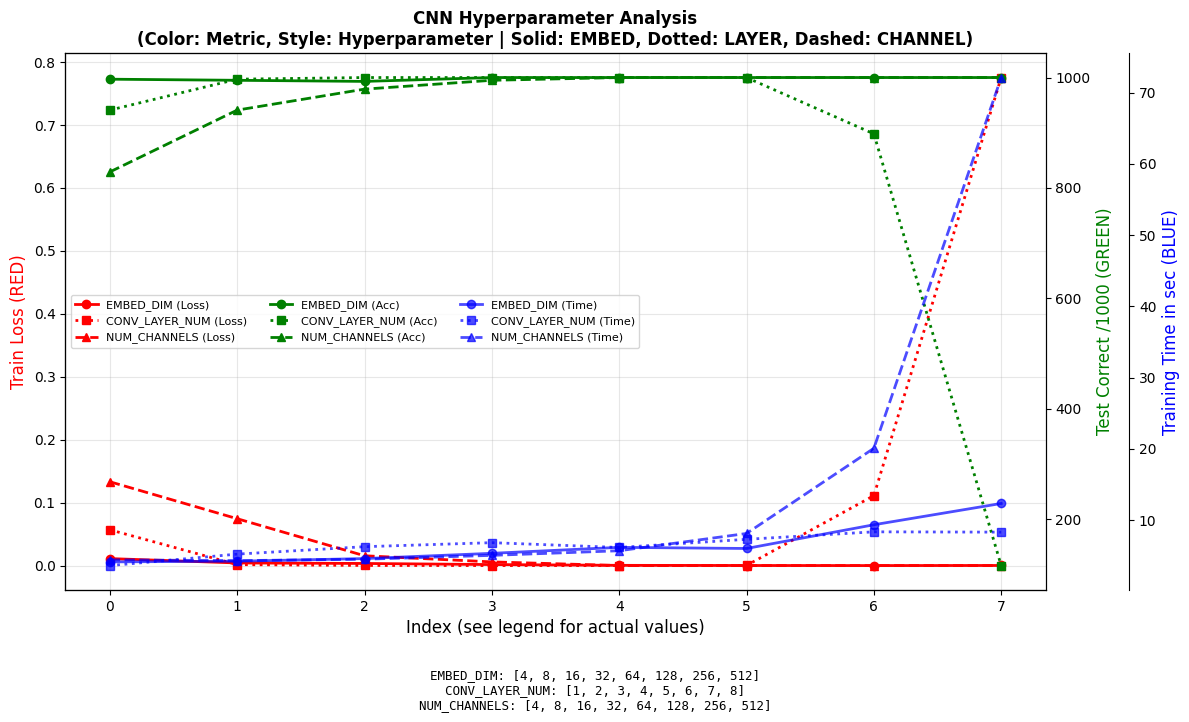

In [6]:
# ============================================================
# Plotting - Single Figure with 3 y-axes
# ============================================================
fig, ax1 = plt.subplots(figsize=(12, 7))

# Create additional y-axes
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

# X-axis: use indices (0 to n-1)
n = len(embed_dims)
x_indices = list(range(n))

# Plot Train Loss (RED) - Left y-axis
# Solid: EMBED_DIM, Dotted: CONV_LAYER_NUM, Dashed: NUM_CHANNELS
l1 = ax1.plot(x_indices, losses_embed, 'r-o', linewidth=2, markersize=6, label='EMBED_DIM (Loss)')
l2 = ax1.plot(x_indices, losses_conv, 'r:s', linewidth=2, markersize=6, label='CONV_LAYER_NUM (Loss)')
l3 = ax1.plot(x_indices, losses_channels, 'r--^', linewidth=2, markersize=6, label='NUM_CHANNELS (Loss)')

# Plot Test Accuracy (GREEN) - Right y-axis 1
l4 = ax2.plot(x_indices, accs_embed, 'g-o', linewidth=2, markersize=6, label='EMBED_DIM (Acc)')
l5 = ax2.plot(x_indices, accs_conv, 'g:s', linewidth=2, markersize=6, label='CONV_LAYER_NUM (Acc)')
l6 = ax2.plot(x_indices, accs_channels, 'g--^', linewidth=2, markersize=6, label='NUM_CHANNELS (Acc)')

# Plot Training Time (BLUE) - Right y-axis 2
l7 = ax3.plot(x_indices, times_embed, 'b-o', linewidth=2, markersize=6, alpha=0.7, label='EMBED_DIM (Time)')
l8 = ax3.plot(x_indices, times_conv, 'b:s', linewidth=2, markersize=6, alpha=0.7, label='CONV_LAYER_NUM (Time)')
l9 = ax3.plot(x_indices, times_channels, 'b--^', linewidth=2, markersize=6, alpha=0.7, label='NUM_CHANNELS (Time)')

# Labels
ax1.set_xlabel('Index (see legend for actual values)', fontsize=12)
ax1.set_ylabel('Train Loss (RED)', fontsize=12, color='red')
ax2.set_ylabel('Test Correct /1000 (GREEN)', fontsize=12, color='green')
ax3.set_ylabel('Training Time in sec (BLUE)', fontsize=12, color='blue')

# Set x-axis ticks
ax1.set_xticks(x_indices)
ax1.set_xticklabels([f'{i}' for i in x_indices])

# Add text annotation for actual values
embed_str   = f"EMBED_DIM: {embed_dims}"
conv_str    = f"CONV_LAYER_NUM: {conv_layers}"
channel_str = f"NUM_CHANNELS: {num_channels_list}"
fig.text(0.5, -0.02, f"{embed_str}\n{conv_str}\n{channel_str}", 
         ha='center', fontsize=9, family='monospace')

# Combine legends
lines  = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center left', fontsize=8, ncol=3)

ax1.grid(True, alpha=0.3)
plt.title('CNN Hyperparameter Analysis\n(Color: Metric, Style: Hyperparameter | Solid: EMBED, Dotted: LAYER, Dashed: CHANNEL)', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

## 3.2. SOTA model analysis

In [28]:
import time
import numpy as np

# ============================================================
# Exhaustive Evaluation: All 10000 cases
# ============================================================
model.eval()

x_values      = []  # num1 * 100 + num2 (0 ~ 9999)
y_values      = []  # deviation (true - pred)
true_labels   = []
pred_labels   = []

start_time = time.time()

with torch.no_grad():
    for num11 in tq(range(10), desc="Exhaustive Test"):
        for num12 in range(10):
            for num21 in range(10):
                for num22 in range(10):
                    # Create input
                    num1 = num11 * 10 + num12
                    num2 = num21 * 10 + num22
                    true_sum = num1 + num2
                    
                    # Prepare input tensor
                    src = torch.tensor([[num11, num12, num21, num22]], dtype=torch.long).to(DEVICE)
                    
                    # Predict
                    logits = model(src)
                    preds  = logits.argmax(-1)  # (1, 3)
                    
                    # Convert prediction to number
                    pred_digits = preds[0].cpu().tolist()
                    pred_sum    = pred_digits[0] * 100 + pred_digits[1] * 10 + pred_digits[2]
                    
                    # Store results
                    x_values.append(num1 * 100 + num2)  # 0 ~ 9999
                    y_values.append(true_sum - pred_sum)  # deviation
                    true_labels.append(true_sum)
                    pred_labels.append(pred_sum)

total_time = time.time() - start_time

# ============================================================
# Calculate Metrics
# ============================================================
x_values    = np.array(x_values)
y_values    = np.array(y_values)
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Correct predictions
correct = np.sum(y_values == 0)
total   = len(y_values)

# Precision & Recall
precision = correct / total if total > 0 else 0
recall    = correct / total if total > 0 else 0

# Deviation statistics
dev_mean = np.mean(y_values)
dev_std  = np.std(y_values)

print("\n" + "=" * 60)
print("SOTA CNN Model - Exhaustive Test Results")
print("=" * 60)
print(f"Total computation time:    {total_time:.4f} seconds")
print(f"Time per iteration:        {total_time / total * 1000:.4f} ms")
print(f"Precision:                 {precision * 100:.2f}% ({correct}/{total})")
print(f"Recall:                    {recall * 100:.2f}%")
print(f"Deviation mean:            {dev_mean:.4f}")
print(f"Deviation std:             {dev_std:.4f}")
print("=" * 60)

Exhaustive Test: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


SOTA CNN Model - Exhaustive Test Results
Total computation time:    9.3301 seconds
Time per iteration:        0.9330 ms
Precision:                 100.00% (10000/10000)
Recall:                    100.00%
Deviation mean:            0.0000
Deviation std:             0.0000


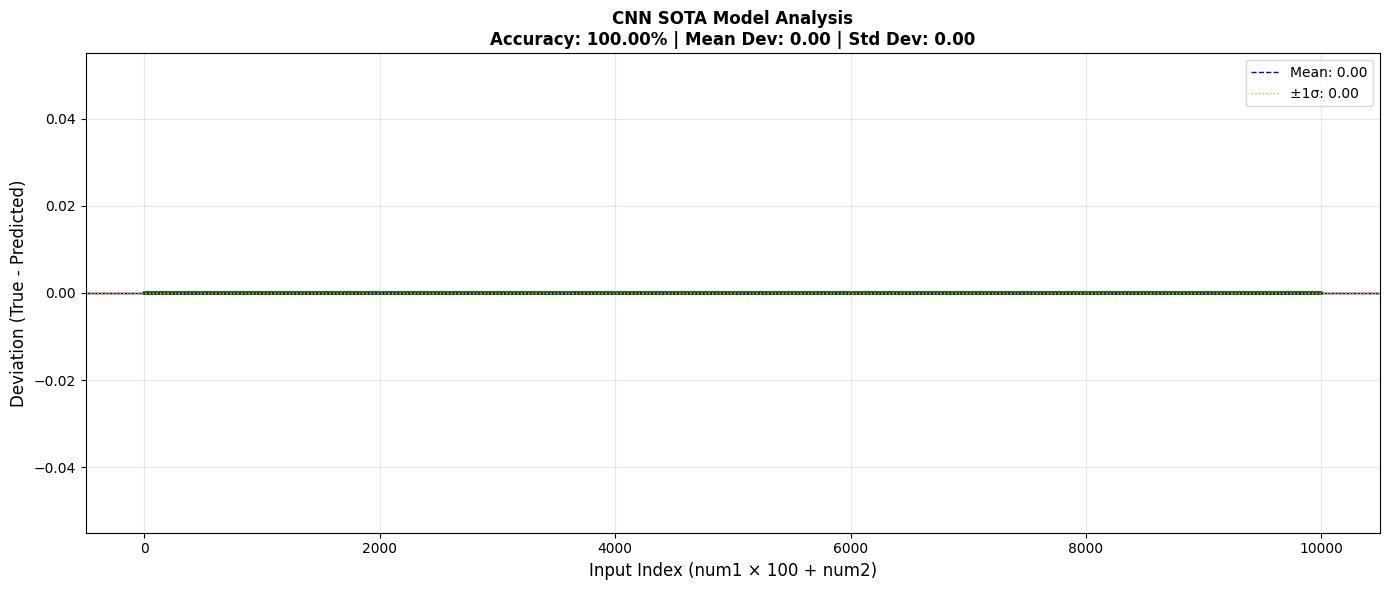


Sample Error Cases (first 10):
--------------------------------------------------


In [29]:
import matplotlib.pyplot as plt

# ============================================================
# Plotting
# ============================================================
fig, ax = plt.subplots(figsize=(14, 6))

# Scatter plot: x = num1*100 + num2 (0~9999), y = deviation
colors = ['green' if d == 0 else 'blue' for d in y_values]
ax.scatter(x_values, y_values, c=colors, alpha=0.5, s=3)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=dev_mean, color='blue', linestyle='--', linewidth=1, label=f'Mean: {dev_mean:.2f}')
ax.axhline(y=dev_mean + dev_std, color='orange', linestyle=':', linewidth=1, label=f'±1σ: {dev_std:.2f}')
ax.axhline(y=dev_mean - dev_std, color='orange', linestyle=':', linewidth=1)

ax.set_xlabel('Input Index (num1 × 100 + num2)', fontsize=12)
ax.set_ylabel('Deviation (True - Predicted)', fontsize=12)
ax.set_title(f'CNN SOTA Model Analysis\nAccuracy: {precision*100:.2f}% | Mean Dev: {dev_mean:.2f} | Std Dev: {dev_std:.2f}', 
             fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show some error examples
print("\nSample Error Cases (first 10):")
print("-" * 50)
error_indices = np.where(y_values != 0)[0][:10]
for idx in error_indices:
    num1 = x_values[idx] // 100
    num2 = x_values[idx] % 100
    print(f"{num1:2d} + {num2:2d} = {true_labels[idx]:3d} | Pred: {pred_labels[idx]:3d} | Dev: {y_values[idx]:+4d}")

# 4. Save the model.

In [26]:
# Save CNN SOTA model (CNN 노트북에서 실행)
import os

os.makedirs('model', exist_ok=True)

torch.save(model.state_dict(), 'model/cnn_2_2_16_lr7e-3.pth')
print("CNN SOTA model saved to model/cnn_2_2_16_lr7e-3.pth")

CNN SOTA model saved to model/cnn_2_2_16_lr7e-3.pth
